# **Homework 5:** PyTorch

### Collaborators

Please list anyone you discussed or collaborated on this assignment with below.

Discuss Q4 and Q13 with Isaac Chung. Discuss Q16 with Maxine Liu.

### Course feedback

Please submit this week's course survey here: https://forms.gle/AjLbyWfWmfKGiX2Z8

## **Part 1:** Vector-Jacobian Products

In the last homework we implemented automatic differentiation in terms of scalar values. For reverse mode, we saw that the update for a node $w$ from a its child $a$ could be written as:
$$\frac{dL}{dw} = \frac{dL}{da}\frac{da}{dw}$$

In this case all three values in this equation were scalars and therefore the computation was quite simple. However we saw that this approach was quite inefficient when dealing with large arrays of numbers. A better approach that we saw in class was to have each node correspond to a *vector* (or possible a matrix). In this case if $\mathbf{w}$ is a length $n$ vector and $\mathbf{a}$ is a length $m$ vector we would say that:
$$\mathbf{w} \in \mathbb{R}^n, \quad \mathbf{a} \in \mathbb{R}^m$$
 corresponding update equation would be written as:
$$ \frac{dL}{d\mathbf{w}} = \frac{dL}{d\mathbf{a}}^T\frac{da}{d\mathbf{w}}$$

Recall that we called this update a *vector-jacobian product*.
#### **Q1** 
Assuming that $L$ is still a scalar ($L\in \mathbb{R}$), what is the *shape* of each term in the equation above?

*Your answer should be as matrix/vector dimensions e.g. $(a \times b)$*

$$\frac{dL}{d\mathbf{w}} = n * 1$$
$$\frac{dL}{d\mathbf{a}} = m * 1$$
$$\frac{d\mathbf{a}}{d\mathbf{w}} = m * n$$

#### **Q2**

Assume that we have the following formula for $\mathbf{a}$:
$$\mathbf{a}= \exp \big( \mathbf{A} \mathbf{w} \big) + \mathbf{w}^2$$
Where $\mathbf{A}$ is a constant $n \times n$ matrix. Given the gradient of $L$ with respect to $\mathbf{a}$: $\frac{dL}{d\mathbf{a}}$, what is the gradient of $L$ with respect to $\mathbf{w}$ ($\frac{dL}{d\mathbf{w}}$) in terms of: $\frac{dL}{d\mathbf{a}}$, $\mathbf{A}$ and $\mathbf{w}$? 

***Hint:** You do **not** need to write a formula for the Jacobian ($\frac{d\mathbf{a}}{d\mathbf{w}}$). As we saw in class many VJPs can be written without definining the Jacobian explicitly (e.g. for element-wise functions). You can use $\odot$ (`\odot`) to denote an element-wise product between vectors:*
$$ \mathbf{a} \odot \mathbf{b} = \begin{bmatrix} 
a_1 b_1 \\
a_2 b_3 \\
\vdots \\
a_d b_d \\
\end{bmatrix}
$$

Your answer:

$$ \frac{dL}{d\mathbf{w}} = \left( \frac{dL}{d\mathbf{a}} \right)^T \odot \left( \mathbf{A}^T \odot \exp(\mathbf{A} \mathbf{w}) \right) + \left( \frac{dL}{d\mathbf{a}} \right)^T \odot 2\mathbf{w}$$

Verify your answer using PyTorch.

In [220]:
import torch
torch.manual_seed(0)

# Setup the variables
A = torch.randn(5, 5)
w = torch.randn(5)
w.requires_grad = True

# Compute the gradient dL_dw with autograd 
a = torch.exp(torch.matmul(A, w)) + w ** 2
L = torch.sum(a)
L.backward()
wgrad = w.grad
wgrad

tensor([ 2.5438, -4.3855,  1.7762, -0.3767,  4.9248])

In [221]:
# Compute your VJP
dL_da = torch.ones_like(a)
dL_dw = torch.matmul(A.T, dL_da * torch.exp(torch.matmul(A, w))) + 2 * w * dL_da

assert torch.all(torch.isclose(wgrad, dL_dw))
dL_dw

tensor([ 2.5438, -4.3855,  1.7762, -0.3767,  4.9248], grad_fn=<AddBackward0>)

## Part 2: Introduction to PyTorch

Now that we've successfully built our own tool for automatic differentiation and neural networks, let's look at an industry-standard tool for accomplishing the same tasks: [PyTorch](https://pytorch.org/tutorials/beginner/basics/intro.html). 

Throughout this homework to may find it helpful to refer to the [PyTorch documentation](https://pytorch.org/docs/stable/index.html), as well as the [lecture notebook on Pytorch](https://colab.research.google.com/drive/1hJoRYXlGT-nRE4LnA9LEjQcy-c2IEy0p?usp=sharing#scrollTo=cmK5TWhhmePR).

We saw in class that we can create a function with *parameters* in PyTorch using the `torch.nn` module that we'll import as just `nn`. We can do this by creating a subclass of `nn.Module` and defining the parameters with `nn.Parameter`.

In [222]:
import torch
from torch import nn
from hw5_support import *


class LinearZeros(nn.Module):
    '''
    A PyTorch module representing a linear/affine function with weights W and bias b: 
        f(X) = XW + b
    W is an (in_dimensions x out_dimensions) matrix and b is an (out_dimensions) vector.

    This version of the Linear module initializes the parameters to 0.
    '''
    def __init__(self, in_dimensions, out_dimensions):
        # Call the nn.Module __init__ function
        super().__init__()

        # Create parameters that we can fit with gradient descent.
        self.weights = nn.Parameter(torch.zeros(in_dimensions, out_dimensions))
        self.bias = nn.Parameter(torch.zeros(out_dimensions))

    def forward(self, x):
        # Compute the function. Note that we use torch.matmul rather than torch.dot!
        # This assumes X is 2-dimensional (a matrix)!
        return torch.matmul(x, self.weights) + self.bias

We can create a 1-dimensional linear function by creating a `LinearZeros` object, specifying that both the input and output dimensions should be `1`. The method `model.parameters()` will give us access to all the weights we can fit with gradient descent.

In [223]:
model = LinearZeros(1, 1)
list(model.parameters())

[Parameter containing:
 tensor([[0.]], requires_grad=True),
 Parameter containing:
 tensor([0.], requires_grad=True)]

We can also call this model just like any other function.

In [224]:
# Create 4 1-dimensional inputs
x = torch.ones((4, 1))

model(x)

tensor([[0.],
        [0.],
        [0.],
        [0.]], grad_fn=<AddBackward0>)

Let's start by creating a simple dataset to use for the next few problems. We'll use a regression dataset similar to the one we saw in class. In this case, I've provied data already split into training and validation sets.

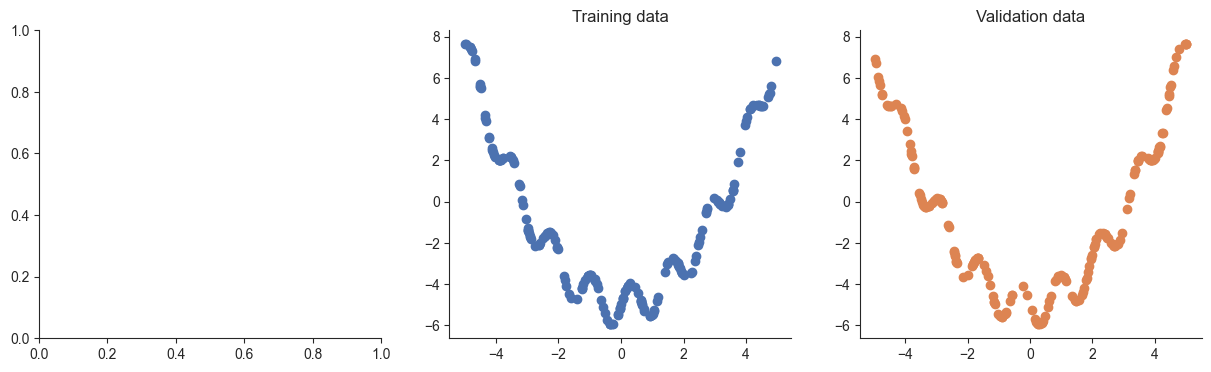

In [225]:
# Create the training inputs and labels
x = torch.rand(200, 1) * 10 - 5.
y = x ** 2 / 2 + torch.sin(x * 5) - 5

# Create the validation inputs and labels
xvalid = torch.rand(200, 1) * 10 - 5.
yvalid = xvalid ** 2 / 2 + torch.sin(xvalid * 5 + torch.pi) - 5

plotRegression(x, y, xvalid, yvalid) 

We can make predictions for our data using the model we just definied:

In [226]:
predictions = model(x)
predictions[:5]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<SliceBackward0>)

However if we plot the prediction function, we'll see that it isn't very good as we haven't optimized the parameters yet:

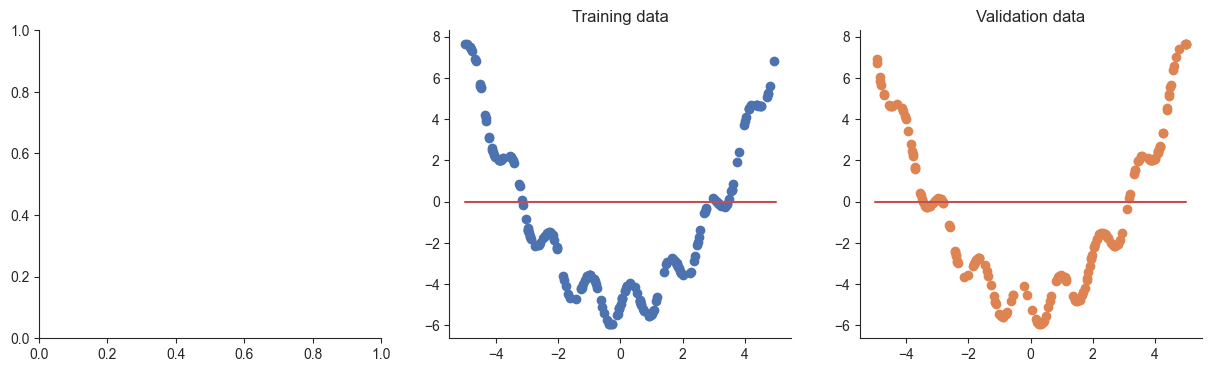

In [227]:
plotRegression(x, y, xvalid, yvalid, model=model) 

The first thing we'll need to optimize our model is a loss function. As we saw in class, the convention in PyTorch is to separate the loss from the model, so we'll write a simple function that takes in predictions and labels, returning the *mean squared error* loss.

#### **Q3**

Complete the `mse_loss` function below. The function should compute the same MSE loss we've seen in previous homeworks, but using **PyTorch** operations.

$$\textbf{Loss}(\mathbf{a}, \mathbf{y}) = \frac{1}{N}\sum_{i=1}^N(a_i - y_i)^2$$

***Hint:** As we see above, our linear module returns a **column-vector** (`predictions` is 2-dimensional), but `y` is just a vector (`y` is 1-dimensional). Make sure to account for this!*

In [228]:
def mse_loss(prediction, labels):
    mse = torch.mean((prediction - labels)**2)
    return mse

# Test to check 
torch.manual_seed(0)
assert torch.isclose(mse_loss(torch.randn(10, 1), torch.randn(10, 1)), torch.tensor(1.1550), 1e-3)

With our loss in hand, we can run gradient descent to optimize our model's parameters. This time, we'll use the `torch.optim` module, which includes many useful variations of gradient descent.

#### **Q4**

Complete the gradient descent function below. The function should:
- Create an `optim.SGD` optimizer for the model's parameters with the specified learning rate
- At each step:
    - Compute the model output and loss (`loss_func`) on the training data
    - Compute the gradients of the loss with respect to the model parameters
    - Take a gradient descent step
    - Reset the parameter gradients to 0
    - Compute the validation loss


In [229]:
from torch import optim

def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=1000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        
        predictions = model(x)
        loss = loss_func(predictions, y) # Compute the gradients of the loss with respect to the model parameters

        loss.backward()
        optimizer.step() # Take a gradient descent step
        optimizer.zero_grad() # Reset the parameter gradients to 0

        valid_predictions = model(xvalid)
        valid_loss = loss_func(valid_predictions, yvalid)
        
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

    return losses, valid_losses

# Test our function
test_gradient_descent(gradient_descent, mse_loss, x, y, xvalid, yvalid)

100%|██████████| 1/1 [00:00<00:00, 1008.00it/s]

Passed!


100%|██████████| 1000/1000 [00:00<00:00, 12894.44it/s]


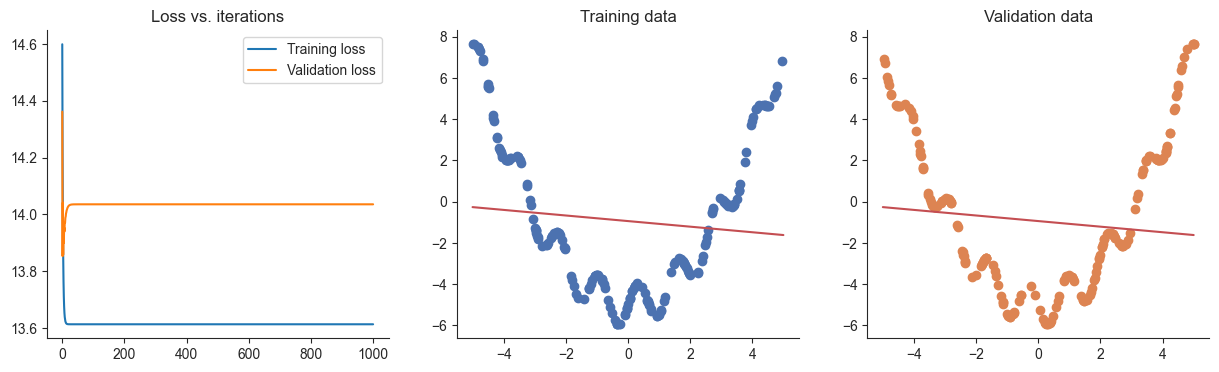

In [230]:
model = LinearZeros(1, 1)
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Now that we have a function to train a PyTorch model, we can try something bigger and more exciting! Let's train a neural network.

#### **Q5**

Create a PyTorch model for a neural network with the following specification:
- The network should have 4 hidden layers, each with 20 neurons
- The network should take 1-dimensional inputs as above
- Each layer should use the LinearZeros module we just wrote
- Each linear layer should be followed by a *ReLU* activation (except the output), use the `nn.ReLU()` module.

***Hint:** Remember that you can use the `nn.Sequential` class to easily compose a sequence of functions in PyTorch.*

Passed!


100%|██████████| 1000/1000 [00:00<00:00, 3715.94it/s]


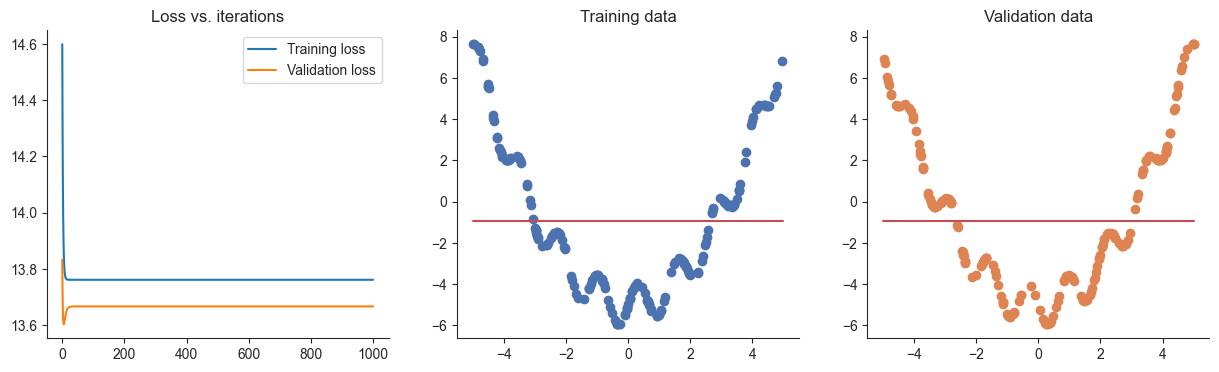

In [231]:
# YOUR CODE HERE
model = nn.Sequential(
    LinearZeros(1, 20),
    nn.ReLU(),
    LinearZeros(20, 20),
    nn.ReLU(),
    LinearZeros(20, 20),
    nn.ReLU(),
    LinearZeros(20, 20),
    nn.ReLU(),
    LinearZeros(20, 1))

# Test the model build
test_build(model, LinearZeros, dropout_type=None, type='zeros')

# Run the model
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q6**

What happened when you attempted to train the model above? Why did this happen? Give a short 1-2 sentence answer.

Because we set the start values of our weights as 0, which is not randomly initialized. This will lead to the gradient of the initial weights are always be 0, making the model not to be trained.

Let's try modifying our Linear module with a different strategy for initialization.

#### **Q7**

Modify the `LinearZeros` implementation from above to initialize the `weights` and `bias` parameters from a *standard normal* distribution $w,b \sim \mathcal{N}(0, 1)$. Then modify your model from **Q6** to use this new module.

***Hint:** You may find the `torch.randn` function useful here. You might also find that the model doesn't train! We'll address this in the next question.*

Passed!
Passed!


100%|██████████| 1000/1000 [00:00<00:00, 3753.95it/s]


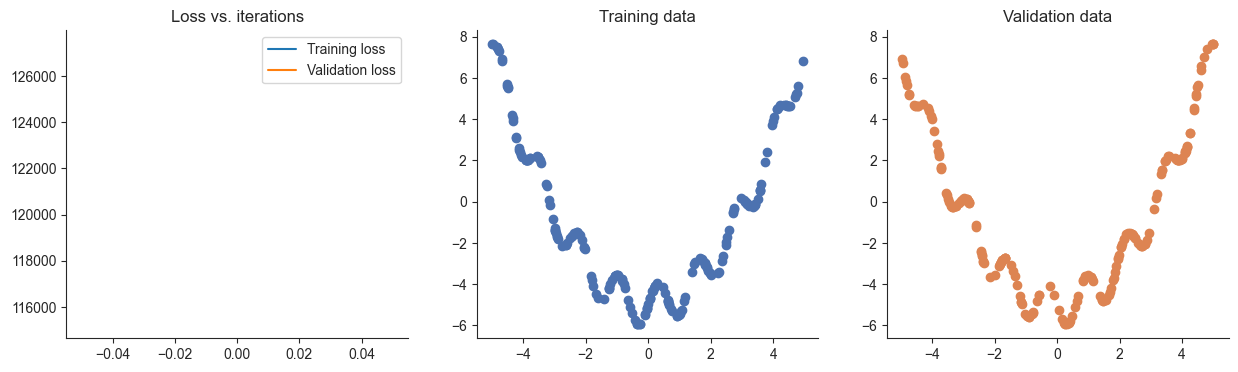

In [232]:
class LinearNormal(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        # YOUR CODE HERE
        self.weights = nn.Parameter(torch.randn(in_dimensions, out_dimensions))
        self.bias = nn.Parameter(torch.randn(out_dimensions))

    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias
    
# YOUR CODE HERE
model = nn.Sequential(
    LinearNormal(1, 20),
    nn.ReLU(),
    LinearNormal(20, 20),
    nn.ReLU(),
    LinearNormal(20, 20),
    nn.ReLU(),
    LinearNormal(20, 20),
    nn.ReLU(),
    LinearNormal(20, 1))

# Test the model build and LinearNormal
test_normal(LinearNormal)
test_build(model, LinearNormal, dropout_type=None, type='normal')

# Run the model
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=0.1)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q8**
In the previous question you might have found that gradient descent didn't work. This could suggest that our learning rate is set wrong. Think about a strategy that you might use to find an appropriate learning rate for fitting this model and try it out below. Then explain the strategy that you used. Is there any way you could improve this strategy to make finding a learning rate quicker?

100%|██████████| 1000/1000 [00:00<00:00, 3276.40it/s]


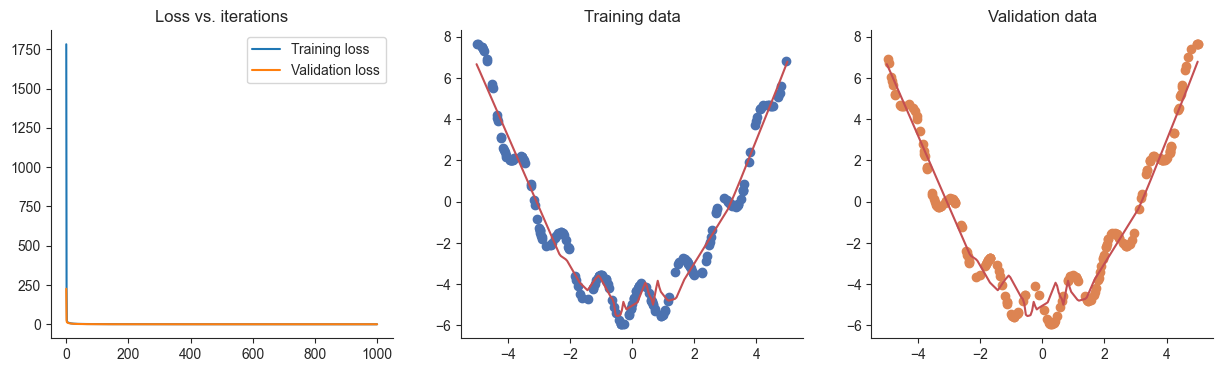

In [233]:
# Modify this code to choose a good learning rate
model = nn.Sequential(
    LinearNormal(1, 20),
    nn.ReLU(),
    LinearNormal(20, 20),
    nn.ReLU(),
    LinearNormal(20, 20),
    nn.ReLU(),
    LinearNormal(20, 1))
lr = 0.0001
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Basically, I first simplified the model by removing one layer of neurons. It makes the optimization process less complex and potentially easier to navigate with gradient descent. Also, I reduced the learning rate to 0.0001. A smaller learning rate can help in situations where the model's parameters need to be adjusted with more precision, preventing overshooting.

In terms of a better way of finding learning rate quicker, I Googled, walked through GeeksforGeeks, and chatted with the ChatGPT. One of the best implementable ways is that implementing a learning rate range test where we start with a small learning rate, increasing it exponentially at each iteration, and observe how the loss changes. The point where the loss starts to increase can give you an indication of an upper bound for the learning rate.

#### **Q9**
We saw in class that a common, useful approach for initializing neural networks is to use a *Kaiming normal* initialization. In this approach we draw each initial weight from a normal distribution where the standard deviation is scaled by the square root of the number of input dimensions to the layer. If $\mathbf{W} \in \mathbb{R}^{d\times e}$ then:
$$w_{ij} \sim \mathcal{N}\bigg(0, \frac{1}{\sqrt{d}}\bigg) \quad \mathbf{W}: d \times e$$
$$b_j = 0 \quad \mathbf{b}: e$$ 
We'll initialize the biases to $0$. Below, implement a linear module using the Kaiming normal initialization, then repeat **Q5** using the `LinearKaiming` class and the learning rate you chose in **Q8**. If needed, adjust the learning rate until your model almost perfectly fits the *training data*.

Passed!
Passed!


100%|██████████| 1000/1000 [00:00<00:00, 3687.70it/s]


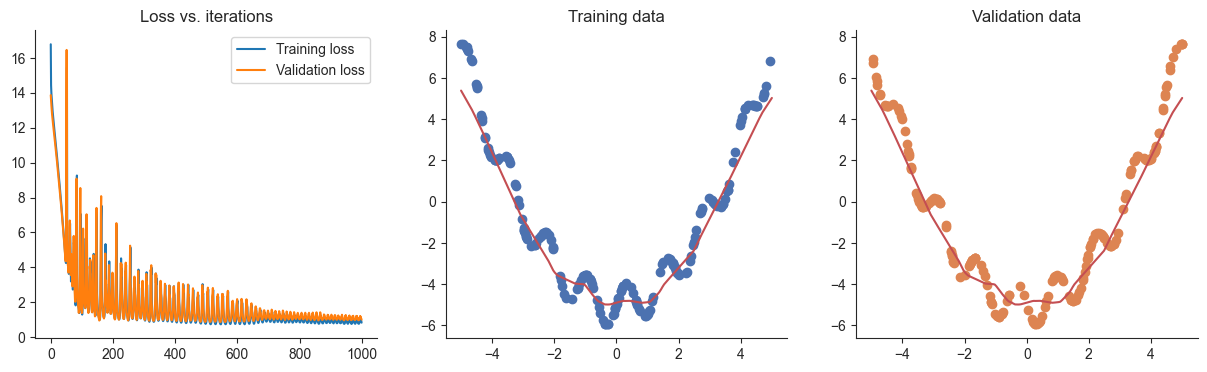

In [234]:
class LinearKaiming(nn.Module):
    def __init__(self, in_dimensions, out_dimensions):
        super().__init__()
        # YOUR CODE HERE
        self.weights = nn.Parameter(torch.randn(in_dimensions, out_dimensions)
                                     * math.sqrt(1 / in_dimensions))
        self.bias = nn.Parameter(torch.zeros(out_dimensions))


    def forward(self, x):
        return torch.matmul(x, self.weights) + self.bias
    
# YOUR CODE HERE
model = nn.Sequential(
    LinearKaiming(1, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 1)
)
lr = 0.01

# Test the model build and LinearKaiming
test_kaiming(LinearKaiming)
test_build(model, LinearKaiming, dropout_type=None, type='normal')

# Run the model
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

If all went well so far, we should find that our model fits our data well, but perhaps a little bit *too* well. Let's try out some of the strategies we've seen to reduce overfitting, starting with early stopping.

#### **Q10** 

Modify your gradient descent algorithm to implment a basic form of early stopping: stop gradient descent as soon as the validation loss increases from the previous iteration. Test this approach with the same model from **Q9**.

 50%|████▉     | 2482/5000 [00:00<00:00, 3804.90it/s]


Early stopping triggered


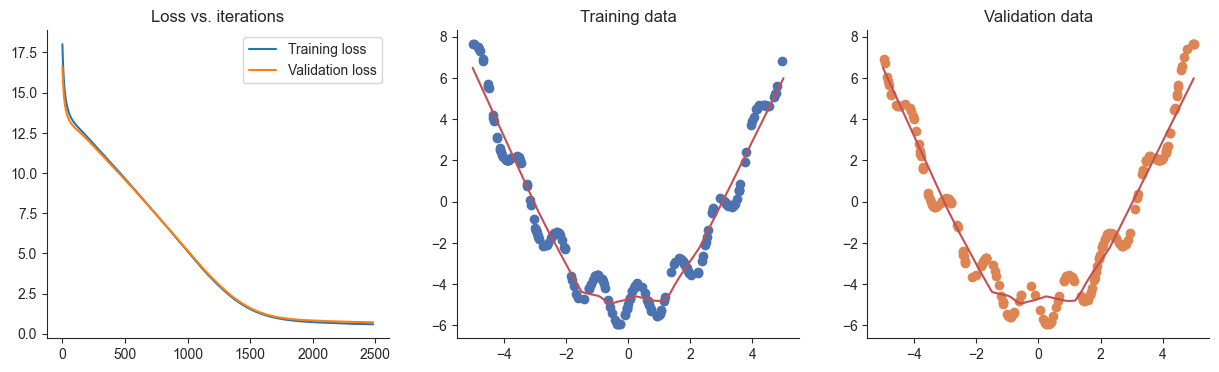

In [235]:
def gradient_descent_early_stopping(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        # YOUR CODE HERE
        predictions = model(x)
        loss = loss_func(predictions, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_predictions = model(xvalid)
        valid_loss = loss_func(valid_predictions, yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

        if len(valid_losses) > 1 and valid_losses[-1] > valid_losses[-2]:
            print("Early stopping triggered")
            break

    return losses, valid_losses

model = nn.Sequential(
    LinearKaiming(1, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 1))

lr = 0.0005
losses, valid_losses = gradient_descent_early_stopping(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

#### **Q11**

Did this approach work as intended? Why or why not? Think about how you might improve this approach and explain any ideas you have in 1-2 sentences.

I would say, for some specific small learning rates (below 0.001), the early stop is always triggered. But it is not always like that because it stops training as soon as the validation loss increases, which could be problematic due to some noisy data (outliers) or too early stopping, which might be caused unwell-tuned learning rate.

The approach to solving this might include 1. waiting for processing more steps after early stop being triggered (set some thresholds), and see if the loss decrease as normal; 2. we call early stop when the AVERAGE loss is above some threshold rather than one loss being greater than some certain value; 3. Force the model is trained above some certain number of times;

#### **Q12**

Modify your early stopping gradient descent so that it always runs for at least 50 iterations. Then after 50 iterations stop if at any point the validation loss is larger than the *average validation loss for the previous 50 iterations*.

 51%|█████▏    | 2569/5000 [00:00<00:00, 3704.42it/s]


Early stopping triggered


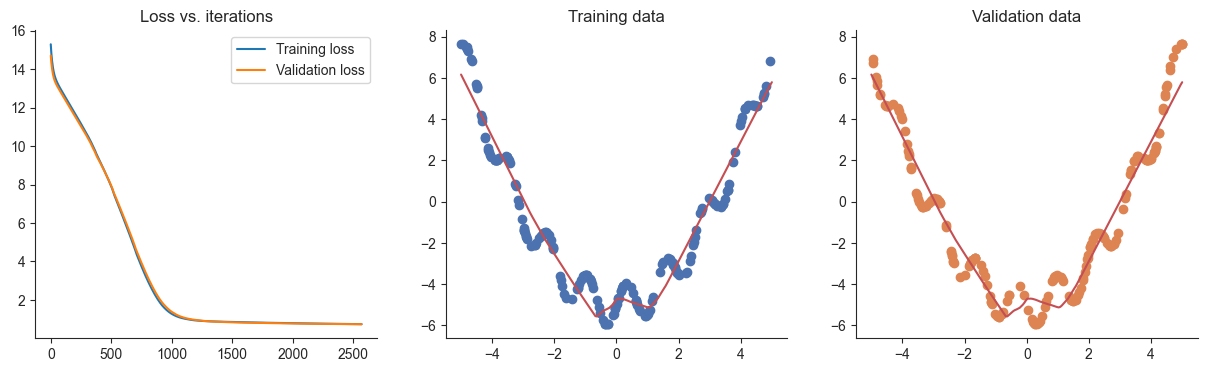

In [236]:

def gradient_descent_patient_early_stopping(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for iteration in tqdm.trange(steps):
        # YOUR CODE HERE
        predictions = model(x)
        loss = loss_func(predictions, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_predictions = model(xvalid)
        valid_loss = loss_func(valid_predictions, yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

        if iteration > 50: # set up at least 50 iterations
            avg_last_50 = np.mean(valid_losses[-51:-1])
            if valid_losses[-1] > avg_last_50:
                print("Early stopping triggered")
                break

    return losses, valid_losses

model = nn.Sequential(
    LinearKaiming(1, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 1))

lr = 0.0005

losses, valid_losses = gradient_descent_patient_early_stopping(model, mse_loss, x, y, xvalid, yvalid, lr=lr)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Now let's try out L1 regualrization! We will consider a scaled version of L1 regularization, where for a $d \times e$ weight matrix $\mathbf{W}$ we will define the L1 loss as:
$$\textbf{Loss}_{L1}(\mathbf{W})= \frac{\lambda}{d e}\sum_{i=1}^d\sum_{j=1}^e |w_{ij}| \quad \mathbf{W}: d \times e$$
Here $\lambda$ is a value that we can choose to control how much weight we put on our L1 loss (we'll call it `l1_weight` below).

#### **Q13**

Modify your original gradient descent algorithm from **Q4** (no early stopping) to add the L1 loss for each parameter in the model to the loss. 

***Hint:** Recall that we can access every parameter in the model using the `model.parameters()` method. In this question you do not need to worry about distinguishing between weights and biases, you can apply L1 regularization to biases as well if it simplifies your approach. Your validation loss should not include the regularization terms.*

In [237]:
from torch import optim

def gradient_descent_l1(model, loss_func, x, y, xvalid, yvalid, lr=0.1, l1_weight=1., steps=5000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        # YOUR CODE HERE
        predictions = model(x)
        loss = loss_func(predictions, y)
        losses.append(loss.detach().numpy()) # Track loss without L2 terms

        l1_loss = 0
        for param in model.parameters():
            l1_loss += param.abs().sum()
        l2_loss = l1_loss / param.numel()
        loss = loss + l1_weight * l2_loss

        # CODE FOR GRAIDENT DESCENT STEP HERE
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        valid_predictions = model(xvalid)
        valid_loss = loss_func(valid_predictions, yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())


    return losses, valid_losses

# Test our function
test_gradient_descent(gradient_descent_l1, mse_loss, x, y, xvalid, yvalid, l1=True)

100%|██████████| 1/1 [00:00<00:00, 798.76it/s]

Passed!


#### **Q14**

Apply `gradient_descent_l1` as in previous problems. Find an appropriate setting of `l1_weight` that minimizes the validation loss.

***Hint:** How you go about choosing `l1_weight` is up to you! Your validation loss should be lower than the validation loss without regularization.*


100%|██████████| 5000/5000 [00:01<00:00, 2564.37it/s]


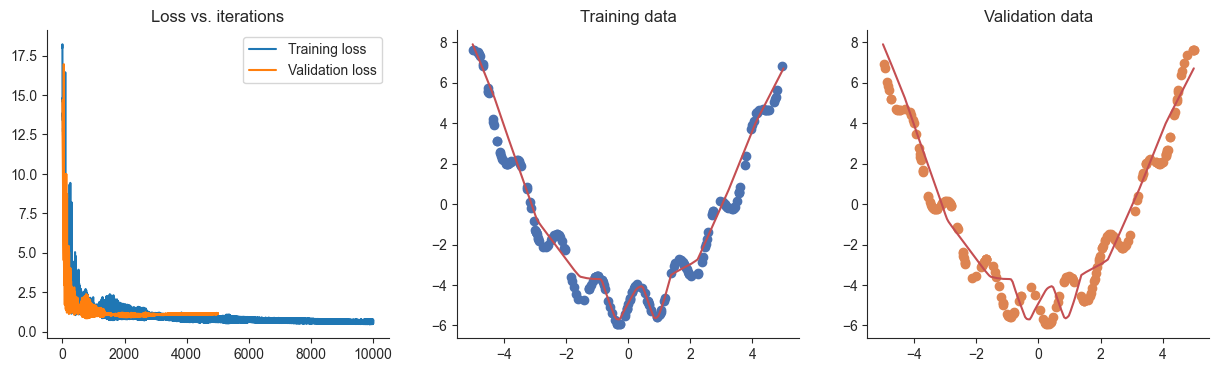

In [238]:
model = nn.Sequential(
    LinearKaiming(1, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 20),
    nn.ReLU(),
    LinearKaiming(20, 1))
lr = 0.01
l1_weight = 0.001  

losses, valid_losses = gradient_descent_l1(model, mse_loss, x, y, xvalid, yvalid, lr=lr, l1_weight=l1_weight)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)

Finally let's try out *dropout* regularization. We will implement dropout as its own module, so we can think of it as a function that transforms a vector or matix into a vector or matrix of the same shape with elements randomly set to $0$. In this case we can write the dropout function as:
$$\text{Dropout}(\mathbf{X}, r) = \mathbf{D} \odot \mathbf{X}, \quad \mathbf{D} =
\begin{bmatrix}
d_{11} & d_{12} & \dots & d_{1n} \\ 
d_{21} & d_{22} & \dots & d_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
d_{m1} & d_{m2} & \dots &  d_{mn}
\end{bmatrix},\ d_{ij} \sim \text{Bernoulli}(1-r)$$

Here $\odot$ denotes element-wise multiplication (so $\mathbf{D}$ and $\mathbf{X}$ are the same shape), $r$ is the dropout rate so $p(d_{ij}=0)=r$.

At evaluation time, we do not want to randomly drop elements. Instead we will scale $\mathbf{X}$ by $(1-r)$:
$$\text{Dropout}_{\text{eval}}(\mathbf{X}, r) = (1-r)\mathbf{X}$$

#### **Q15**
Complete the implementation of the `Dropout` module below.

***Hint:** The built-in `training` property of an `nn.Module` instance specifies if our model is in training mode or evaluation mode. By default models are in training mode (`training == True`), but we can set a model to evaluation mode by calling `model.eval()`. Then we can use `model.train()` to set it back to training mode.*

*You may find the function `torch.rand_like()` helpful for this problem. You might also find it helpful to know that you can convert and `boolean` tensor `X` into a `float` tensor by calling `X.float()` (`True` becomes `1.`, `False` becomes `0.`)*

In [239]:
class Dropout(nn.Module):
    def __init__(self, rate=0.01):
        # Rate specifies the dropout rate (r)
        super().__init__()
        self.rate = rate

    def forward(self, x):
        # YOUR CODE HERE
        if self.training:
            dropout = (torch.rand_like(x) > self.rate).float()
            return dropout * x
        else:
            return (1 - self.rate) * x

# Test our module
test_dropout(Dropout)

Passed!


#### **Q16**

Modify your `gradient_descent` function to put the model into `train` mode before calculating the training loss and into `eval` mode before calculating the validation loss. Then create a model based on your network from **Q9**, but this time add a `Dropout` layer before each `LinearKaiming` layer. You can use the default dropout rate of `0.01` or try something different! Verify that dropout gives different results to previous approaches.

Passed!


100%|██████████| 10000/10000 [00:04<00:00, 2410.40it/s]


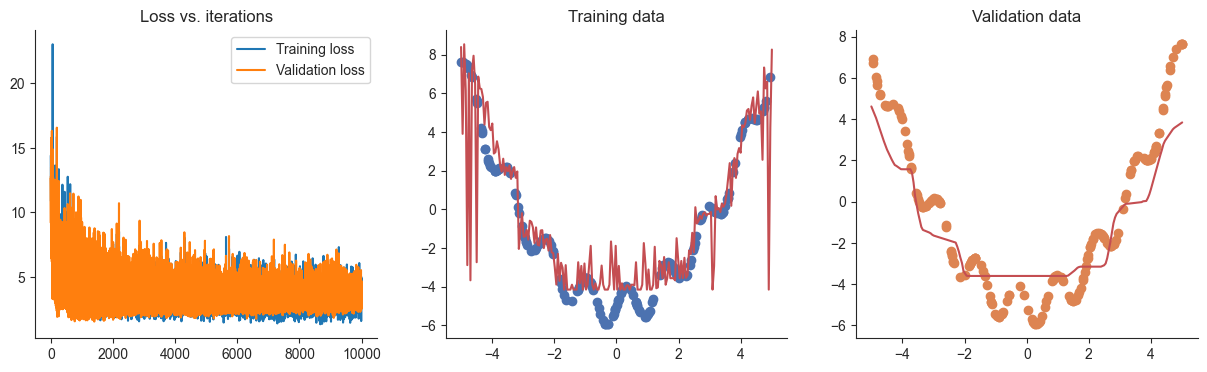

In [285]:
from torch import optim

def gradient_descent(model, loss_func, x, y, xvalid, yvalid, lr=0.1, steps=10000):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    losses = []
    valid_losses = []
    for _ in tqdm.trange(steps):
        # YOUR CODE HERE
        model.train()

        predictions = model(x)
        loss = loss_func(predictions, y)
        

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        valid_predictions = model(xvalid)
        valid_loss = loss_func(valid_predictions, yvalid)
        losses.append(loss.detach().numpy())
        valid_losses.append(valid_loss.detach().numpy())

    return losses, valid_losses


# YOUR CODE HERE
model = nn.Sequential(
    Dropout(0.08),
    LinearKaiming(1, 20),
    nn.ReLU(),
    Dropout(0.1),
    LinearKaiming(20, 20),
    nn.ReLU(),
    Dropout(0.2),
    LinearKaiming(20, 20),
    nn.ReLU(),
    Dropout(0.1),
    LinearKaiming(20, 20),
    nn.ReLU(),
    Dropout(0.08),
    LinearKaiming(20, 1))

# Test our model build
test_build(model, LinearKaiming, dropout_type=Dropout, type='normal')

lr = 0.0083
losses, valid_losses = gradient_descent(model, mse_loss, x, y, xvalid, yvalid)
plotRegression(x, y, xvalid, yvalid, loss_history=losses, valid_loss_history=valid_losses, model=model)